## Imports

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from datetime import datetime, timedelta

# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)


# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Mon Apr  5 13:24:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Re-Format Time

## Load the MNIST Dataset

In [3]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw

Processing...
Done!


In [4]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [5]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [6]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


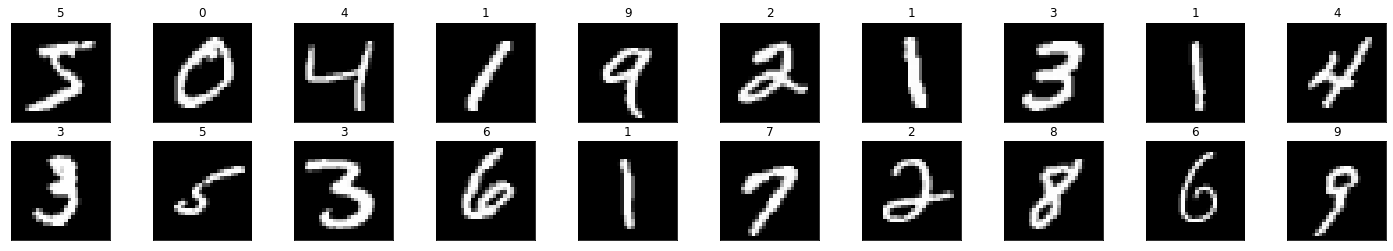

In [8]:
visualize(mnist_data_train)

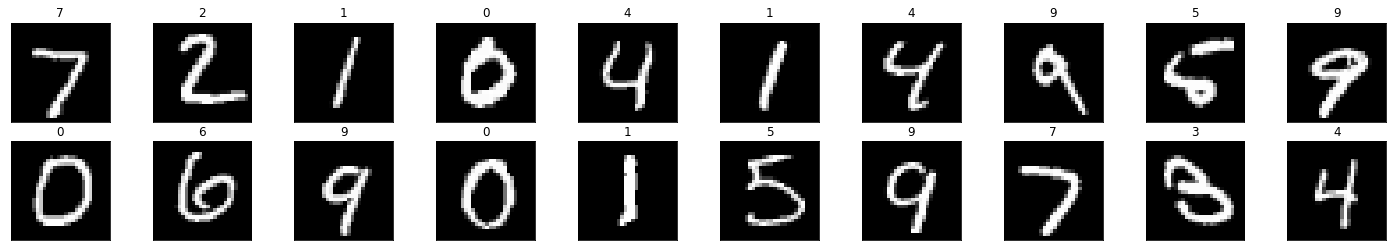

In [9]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [10]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict

## Models

In [11]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.fc2 = nn.Linear(200, 200)
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    out = self.fc3(x)

    return x

In [12]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

### Print Model Summaries

In [13]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (28,28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 8, 8]          51,264

## Testing Loop

In [14]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  # print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  # for i in range(10):
  #   if total_class[i]>0:
  #     print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
  #           (classes[i], 100 * correct_class[i] / total_class[i],
  #           np.sum(correct_class[i]), np.sum(total_class[i])))
  #   else:
  #     print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  # print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
  #       100. * np.sum(correct_class) / np.sum(total_class),
  #       np.sum(correct_class), np.sum(total_class)))
  return test_loss, test_accuracy

## FedProx

### Systems Heterogeneity Simulations

Generate epochs for selected clients based on percentage of devices that corresponds to heterogeneity. 

Assign x number of epochs (chosen unifirmly at random between [1, E]) to 0%, 50% or 90% of the selected devices, respectively. Settings where 0% devices perform fewer than E epochs of work correspond to the environments without system heterogeneity, while 90% of the devices sending their partial solutions corresponds to highly heterogenous system.

In [15]:
def GenerateLocalEpochs(percentage, size, max_epochs):
  ''' Method generates list of epochs for selected clients
  to replicate system heteroggeneity

  Params:
    percentage: percentage of clients to have fewer than E epochs
    size:       total size of the list
    max_epochs: maximum value for local epochs
  
  Returns:
    List of size epochs for each Client Update

  '''

  # if percentage is 0 then each client runs for E epochs
  if percentage == 0:
      return np.array([max_epochs]*size)
  else:
    # get the number of clients to have fewer than E epochs
    heterogenous_size = int((percentage/100) * size)

    # generate random uniform epochs of heterogenous size between 1 and E
    epoch_list = np.random.randint(1, max_epochs, heterogenous_size)

    # the rest of the clients will have E epochs
    remaining_size = size - heterogenous_size
    rem_list = [max_epochs]*remaining_size

    epoch_list = np.append(epoch_list, rem_list, axis=0)
    
    # shuffle the list and return
    np.random.shuffle(epoch_list)

    return epoch_list

### Local Training (Client Update)

Local training for the model on client side

In [16]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs, mu, algorithm):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True)
    self.algorithm = algorithm
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):
    # print("Client training for {} epochs.".format(self.epochs))
    criterion = nn.CrossEntropyLoss()
    proximal_criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)

    # use the weights of global model for proximal term calculation
    global_model = copy.deepcopy(model)

    # calculate local training time
    start_time = time.time()


    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)

        # calculate the loss + the proximal term
        _, pred = torch.max(output, 1)

        if self.algorithm == 'fedprox':
          proximal_term = 0.0

          # iterate through the current and global model parameters
          for w, w_t in zip(model.parameters(), global_model.parameters()) :
            # update the proximal term 
            #proximal_term += torch.sum(torch.abs((w-w_t)**2))
            proximal_term += (w-w_t).norm(2)

          loss = criterion(output, labels) + (mu/2)*proximal_term
        else:
          loss = criterion(output, labels)
    
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss, (time.time() - start_time)

### Server Side Training

Following Algorithm 1 from the paper

In [17]:
def training(model, rounds, batch_size, lr, ds, data_dict, test_data_dict, C, K, E, mu, percentage, plt_title, plt_color, target_test_accuracy, algorithm="fedprox"):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - test_data_dict:  Data used for testing the model
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - mu:              proximal term constant
    - percentage:      percentage of selected client to have fewer than E epochs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # store last loss for convergence
  last_loss = 0.0

  # total time taken 
  total_time = 0

  print(f"System heterogeneity set to {percentage}% stragglers.\n")
  print(f"Picking {max(int(C*K),1 )} random clients per round.\n")

  for curr_round in range(1, rounds+1):
    w, local_loss, lst_local_train_time = [], [], []

    m = max(int(C*K), 1)

    heterogenous_epoch_list = GenerateLocalEpochs(percentage, size=m, max_epochs=E)
    heterogenous_epoch_list = np.array(heterogenous_epoch_list)

    S_t = np.random.choice(range(K), m, replace=False)
    S_t = np.array(S_t)
    
    # For Federated Averaging, drop all the clients that are stragglers
    if algorithm == 'fedavg':
      stragglers_indices = np.argwhere(heterogenous_epoch_list < E)
      heterogenous_epoch_list = np.delete(heterogenous_epoch_list, stragglers_indices)
      S_t = np.delete(S_t, stragglers_indices)

    for k, epoch in zip(S_t, heterogenous_epoch_list):
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=epoch, idxs=data_dict[k], mu=mu, algorithm=algorithm)
      weights, loss, local_train_time = local_update.train(model=copy.deepcopy(model))

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      lst_local_train_time.append(local_train_time)

    # calculate time to update the global weights
    global_start_time = time.time()

    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    global_end_time = time.time()

    # calculate total time 
    total_time += (global_end_time - global_start_time) + sum(lst_local_train_time)/len(lst_local_train_time)

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)

    # test accuracy
    criterion = nn.CrossEntropyLoss()
    test_loss, test_accuracy = testing(model, test_data_dict, 128, criterion, num_classes, classes_test)
    


    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 3)}... \tTest Loss: {test_loss}... \tTest Accuracy: {test_accuracy}")
    train_loss.append(loss_avg)

    test_acc.append(test_accuracy)
    # break if we achieve the target test accuracy
    if test_accuracy >= target_test_accuracy:
      rounds = curr_round
      break

    # break if we achieve convergence, i.e., loss between two consecutive rounds is <0.0001
    if algorithm == 'fedprox' and abs(loss_avg - last_loss) < 0.0001:
      rounds = curr_round
      break
    
    # update the last loss
    last_loss = loss_avg

  # plot train loss
  fig, ax = plt.subplots()
  x_axis = np.arange(1, rounds+1)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax.grid()
  fig.savefig(plt_title+'.jpg', format='jpg')

  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, rounds+1)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  fig1.savefig(plt_title+'-test.jpg', format='jpg')
  
  print("Training Done!")
  # print("Total time taken to Train: {}".format(get_time_format(total_time)))

  return model 

## MNIST CNN on Non IID

### Train


### **MNIST CNN  10 clients**





System heterogeneity set to 0% stragglers.

Picking 1 random clients per round.

Round: 1... 	Average Train Loss: 0.066... 	Test Loss: 8.154506861877442... 	Test Accuracy: 20.253164556962027
Round: 2... 	Average Train Loss: 0.004... 	Test Loss: 8.925781465148926... 	Test Accuracy: 20.253164556962027
Round: 3... 	Average Train Loss: 0.049... 	Test Loss: 9.313096945190429... 	Test Accuracy: 18.354430379746834
Round: 4... 	Average Train Loss: 0.052... 	Test Loss: 8.027756640625... 	Test Accuracy: 21.0126582278481
Round: 5... 	Average Train Loss: 0.015... 	Test Loss: 10.625732675170898... 	Test Accuracy: 10.50632911392405
Round: 6... 	Average Train Loss: 0.016... 	Test Loss: 6.6339098182678224... 	Test Accuracy: 21.0126582278481
Round: 7... 	Average Train Loss: 0.033... 	Test Loss: 6.971316448974609... 	Test Accuracy: 21.139240506329113
Round: 8... 	Average Train Loss: 0.027... 	Test Loss: 6.221756805419922... 	Test Accuracy: 25.063291139240505
Round: 9... 	Average Train Loss: 0.007... 	Te

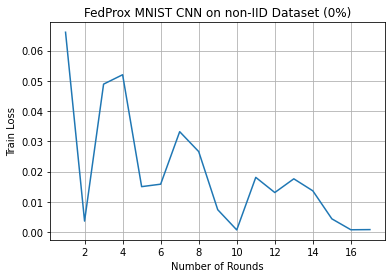

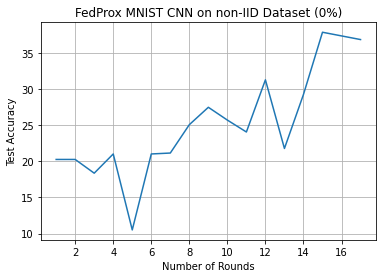

In [ ]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 10
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0

# target_test_accuracy
target_test_accuracy=99.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


### **MNIST CNN  50 clients**




System heterogeneity set to 0% stragglers.

Picking 5 random clients per round.

Round: 1... 	Average Train Loss: 0.046... 	Test Loss: 2.269917056655884... 	Test Accuracy: 29.746835443037973
Round: 2... 	Average Train Loss: 0.017... 	Test Loss: 3.340789712524414... 	Test Accuracy: 23.544303797468356
Round: 3... 	Average Train Loss: 0.026... 	Test Loss: 1.955803483581543... 	Test Accuracy: 38.10126582278481
Round: 4... 	Average Train Loss: 0.031... 	Test Loss: 1.5638021461486817... 	Test Accuracy: 55.18987341772152
Round: 5... 	Average Train Loss: 0.027... 	Test Loss: 1.3105642665863038... 	Test Accuracy: 65.56962025316456
Round: 6... 	Average Train Loss: 0.013... 	Test Loss: 0.6957640402793884... 	Test Accuracy: 79.24050632911393
Round: 7... 	Average Train Loss: 0.015... 	Test Loss: 0.6630096573829651... 	Test Accuracy: 75.82278481012658
Round: 8... 	Average Train Loss: 0.009... 	Test Loss: 0.37918852035999295... 	Test Accuracy: 88.48101265822785
Round: 9... 	Average Train Loss: 0.006.

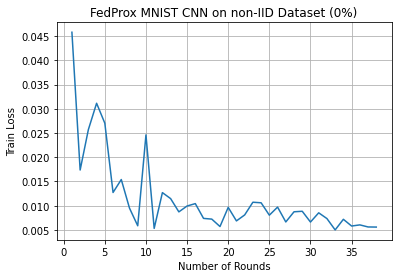

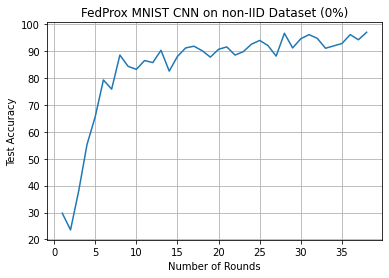

In [22]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 50
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0

# target_test_accuracy
target_test_accuracy=99.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


###**MNIST CNN 100 clients**







System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.051... 	Test Loss: 2.975716375732422... 	Test Accuracy: 8.60759493670886
Round: 2... 	Average Train Loss: 0.029... 	Test Loss: 2.0094653156280518... 	Test Accuracy: 35.31645569620253
Round: 3... 	Average Train Loss: 0.021... 	Test Loss: 1.9496319538116456... 	Test Accuracy: 47.08860759493671
Round: 4... 	Average Train Loss: 0.023... 	Test Loss: 0.908429721069336... 	Test Accuracy: 66.9620253164557
Round: 5... 	Average Train Loss: 0.013... 	Test Loss: 0.8011016345977783... 	Test Accuracy: 70.88607594936708
Round: 6... 	Average Train Loss: 0.018... 	Test Loss: 0.7569603543281556... 	Test Accuracy: 67.84810126582279
Round: 7... 	Average Train Loss: 0.02... 	Test Loss: 0.3866415404319763... 	Test Accuracy: 84.17721518987342
Round: 8... 	Average Train Loss: 0.012... 	Test Loss: 0.7068312789916992... 	Test Accuracy: 75.18987341772151
Round: 9... 	Average Train Loss: 0.01... 	T

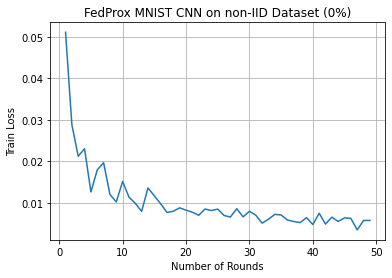

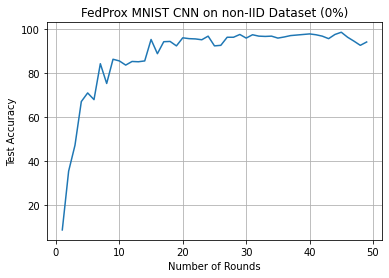

In [18]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0

# target_test_accuracy
target_test_accuracy=99.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_cnn.cuda()

mnist_cnn_non_iid_trained = training(mnist_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST CNN on non-IID Dataset (0%)", "green", target_test_accuracy)


## MNIST MLP on Non IID

### Train

###**MNIST MLP  10 clients**



System heterogeneity set to 0% stragglers.

Picking 1 random clients per round.

Round: 1... 	Average Train Loss: 0.061... 	Test Loss: 11.277280123901367... 	Test Accuracy: 18.734177215189874
Round: 2... 	Average Train Loss: 0.033... 	Test Loss: 11.379000196838378... 	Test Accuracy: 10.50632911392405
Round: 3... 	Average Train Loss: 0.019... 	Test Loss: 10.061495538330078... 	Test Accuracy: 18.734177215189874
Round: 4... 	Average Train Loss: 0.036... 	Test Loss: 9.263470463562012... 	Test Accuracy: 20.88607594936709
Round: 5... 	Average Train Loss: 0.001... 	Test Loss: 9.46797042388916... 	Test Accuracy: 20.50632911392405
Round: 6... 	Average Train Loss: 0.048... 	Test Loss: 8.944220808410645... 	Test Accuracy: 21.772151898734176
Round: 7... 	Average Train Loss: 0.007... 	Test Loss: 8.572625555419922... 	Test Accuracy: 25.443037974683545
Round: 8... 	Average Train Loss: 0.012... 	Test Loss: 8.059337284851074... 	Test Accuracy: 26.455696202531644
Round: 9... 	Average Train Loss: 0.004..

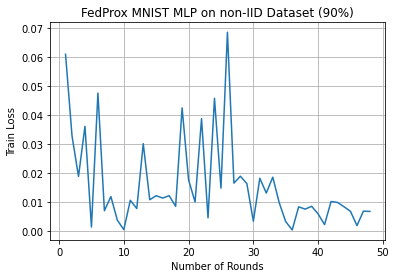

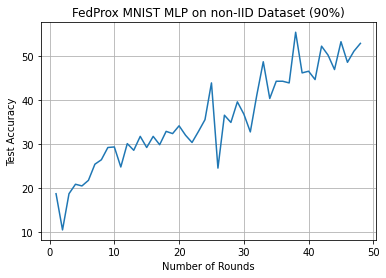

In [26]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 10
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)

###**MNIST MLP 50 clients**


System heterogeneity set to 0% stragglers.

Picking 5 random clients per round.

Round: 1... 	Average Train Loss: 0.065... 	Test Loss: 4.772037729644776... 	Test Accuracy: 23.037974683544302
Round: 2... 	Average Train Loss: 0.034... 	Test Loss: 3.6412127380371095... 	Test Accuracy: 28.227848101265824
Round: 3... 	Average Train Loss: 0.033... 	Test Loss: 2.605280894470215... 	Test Accuracy: 32.65822784810127
Round: 4... 	Average Train Loss: 0.021... 	Test Loss: 2.0213088695526125... 	Test Accuracy: 48.734177215189874
Round: 5... 	Average Train Loss: 0.024... 	Test Loss: 1.2012098838806153... 	Test Accuracy: 62.78481012658228
Round: 6... 	Average Train Loss: 0.019... 	Test Loss: 1.2472706525802613... 	Test Accuracy: 56.45569620253165
Round: 7... 	Average Train Loss: 0.018... 	Test Loss: 1.7886881725311279... 	Test Accuracy: 45.822784810126585
Round: 8... 	Average Train Loss: 0.013... 	Test Loss: 2.3011258514404296... 	Test Accuracy: 43.29113924050633
Round: 9... 	Average Train Loss: 0.02

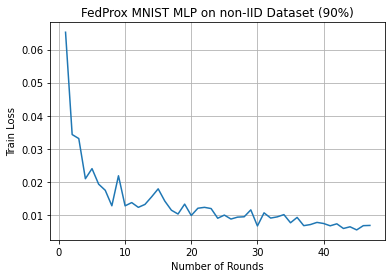

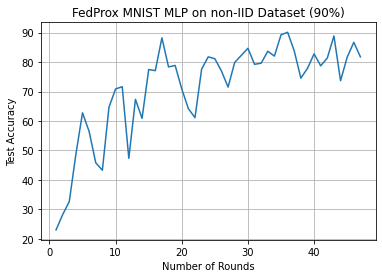

In [27]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 50
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)

###**MNIST MLP  100 clients**


System heterogeneity set to 0% stragglers.

Picking 10 random clients per round.

Round: 1... 	Average Train Loss: 0.058... 	Test Loss: 3.582161156463623... 	Test Accuracy: 24.936708860759495
Round: 2... 	Average Train Loss: 0.036... 	Test Loss: 2.737739862060547... 	Test Accuracy: 33.54430379746835
Round: 3... 	Average Train Loss: 0.024... 	Test Loss: 2.268880011367798... 	Test Accuracy: 37.721518987341774
Round: 4... 	Average Train Loss: 0.019... 	Test Loss: 1.4209910974502564... 	Test Accuracy: 50.50632911392405
Round: 5... 	Average Train Loss: 0.022... 	Test Loss: 1.7813081687927246... 	Test Accuracy: 46.45569620253165
Round: 6... 	Average Train Loss: 0.02... 	Test Loss: 1.1373892217636108... 	Test Accuracy: 66.45569620253164
Round: 7... 	Average Train Loss: 0.022... 	Test Loss: 0.6660212125778199... 	Test Accuracy: 77.9746835443038
Round: 8... 	Average Train Loss: 0.018... 	Test Loss: 0.7604314726829529... 	Test Accuracy: 71.89873417721519
Round: 9... 	Average Train Loss: 0.024...

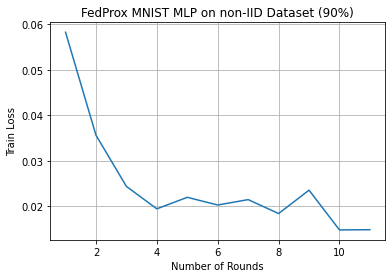

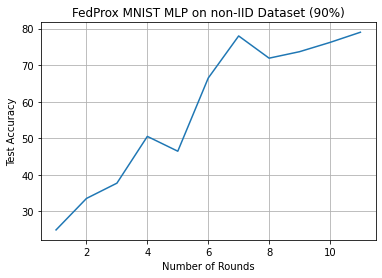

In [28]:
# number of training rounds
rounds = 100
# client fraction
C = 0.1
# number of clients
K = 100
# number of training passes on local dataset for each roung
E = 20
# batch size
batch_size = 10
# learning Rate
lr=0.01
# proximal term constant
mu = 0.01
# percentage of clients to have fewer than E epochs
percentage = 0
# target_test_accuracy
target_test_accuracy=94.0
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 100, 200, 300, 2)
# load model
mnist_mlp = MNIST_2NN()

if torch.cuda.is_available():
  mnist_mlp.cuda()

mnist_mlp_non_iid_trained = training(mnist_mlp, rounds, batch_size, lr, mnist_data_train, data_dict, mnist_data_test, C, K, E, mu, percentage, "FedProx MNIST MLP on non-IID Dataset (90%)", "green", target_test_accuracy)